In [1]:
import pickle
import warnings
import random
import umap
import torch

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance
from scipy import stats
from sklearn import decomposition
from IPython.display import display, Markdown

from torch.nn import functional as F

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [4]:
embeds, rows = [], []

titles = set()

for path in tqdm(glob('../data/b13-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            
            title = ' '.join(line.pop('tokens'))
            
            if title not in titles:
                embeds.append(line.pop('embedding'))
                rows.append(OrderedDict(title=title, **line))
                titles.add(title)

100%|██████████| 99/99 [00:37<00:00,  3.96it/s]


In [5]:
embeds = np.stack(embeds)

In [6]:
df = pd.DataFrame(rows)

In [7]:
df.label.unique()

array(['dailycaller.com', 'thehill.com', 'bloomberg.com', 'breitbart.com',
       'buzzfeed.com', 'cnn.com', 'nytimes.com', 'apnews.com',
       'huffingtonpost.com', 'washingtonpost.com', 'wsj.com',
       'foxnews.com', 'dailykos.com'], dtype=object)

In [8]:
embeds.shape

(864524, 512)

In [9]:
df['p_true'] = df.apply(lambda r: r[f'p_{r.label}'], axis=1)

In [58]:
def plot_umap(domain, umap_frac=1, altair_frac=0.1):
    
    display(Markdown(f'# {domain}'))
    
    dfp = df[df.label==domain].sample(frac=umap_frac)
    dr = umap.UMAP(metric='cosine', verbose=True)
    embedding = dr.fit_transform(embeds[dfp.index])
    
    points = dfp.copy()
    points['x'] = embedding[:,0]
    points['y'] = embedding[:,1]

    points['x_zscore'] = abs(stats.zscore(points.x))
    points['y_zscore'] = abs(stats.zscore(points.y))
    points = points[(points['x_zscore'] < 3) & (points['y_zscore'] < 3)]

    points['logc'] = np.log10(points['count'])

    plt.figure(figsize=(15,15))

    sns.scatterplot(
        x='x', y='y',
        data=points,
        s=10,
        edgecolor=None,
        alpha=0.5,
        hue='p_true',
        palette='viridis'
    )
    
    plt.show()
    
#     chart = (alt
#         .Chart(points.sample(frac=altair_frac), height=500, width=500)
#         .mark_circle()
#         .encode(x='x', y='y', color='p_true', tooltip='title'))
    
#     chart.display()

# thehill.com

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


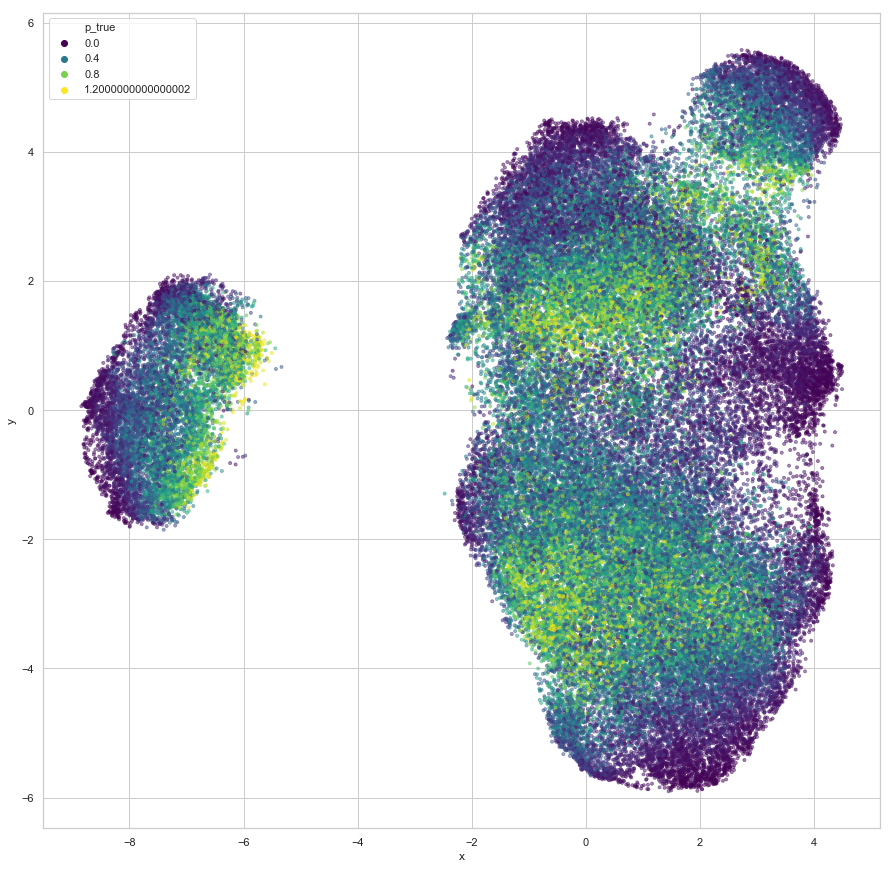

In [59]:
plot_umap('thehill.com')

# bloomberg.com

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


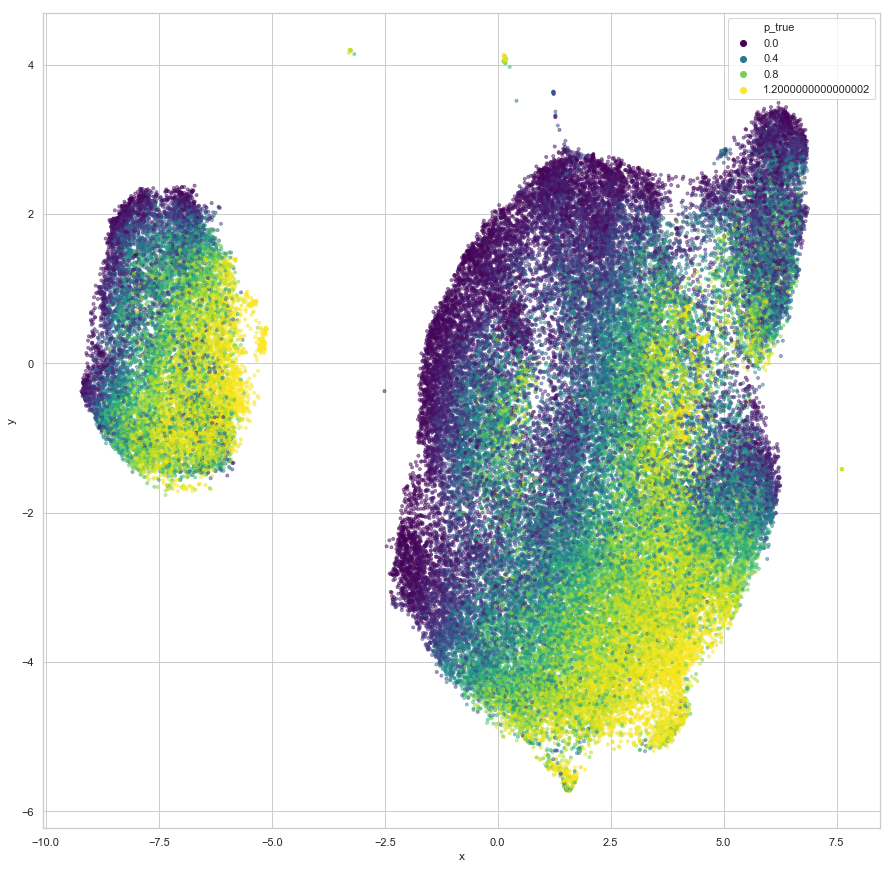

In [60]:
plot_umap('bloomberg.com')

In [64]:
dfp = df[df.label.isin(['wsj.com'])].sample(frac=1)
dr = decomposition.TruncatedSVD(10)
embedding = dr.fit_transform(embeds[dfp.index])

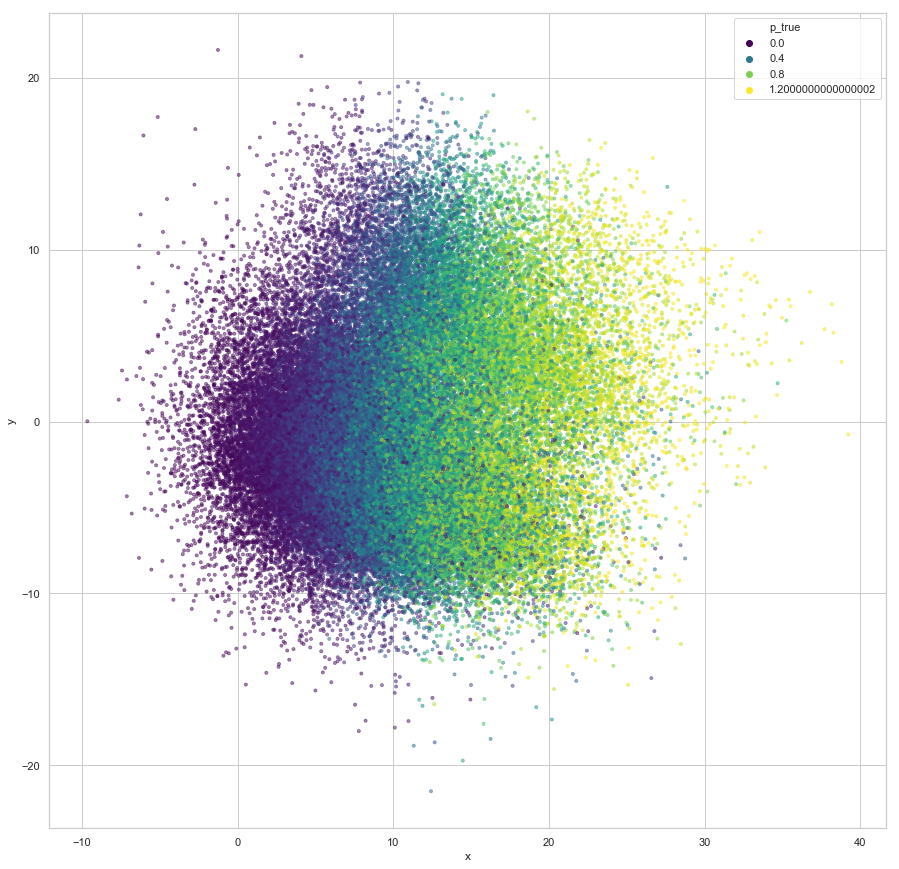

In [67]:
points = dfp.copy()
points['x'] = embedding[:,0]
points['y'] = embedding[:,1]

points['x_zscore'] = abs(stats.zscore(points.x))
points['y_zscore'] = abs(stats.zscore(points.y))

points['logc'] = np.log10(points['count'])

plt.figure(figsize=(15,15))

sns.scatterplot(
    x='x', y='y',
    data=points,
    s=10,
    edgecolor=None,
    alpha=0.5,
    hue='p_true',
    palette='viridis'
)

plt.show()

# chart = (alt
#     .Chart(points.sample(frac=0.1), height=500, width=500)
#     .mark_circle()
#     .encode(x='x', y='y', color='p_true', tooltip='title'))

# chart.display()

In [68]:
dr.explained_variance_ratio_

array([0.19145763, 0.16848548, 0.12137422, 0.08583665, 0.08606526,
       0.07966249, 0.06281407, 0.04813066, 0.04415748, 0.03559895],
      dtype=float32)